In [1]:
# import the required packages
#!pip install nltk==3.6.1
#!pip install numpy==1.18.5
#!pip install pandas==1.3.0
#!pip install torch==1.9.0
#!pip install tqdm==4.59.0
#!pip install scikit_learn==1.0.2

In [1]:
# import the required libraries
import re
import torch
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
from nltk.tokenize import word_tokenize
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [10]:
import os
os.getcwd()

'/Users/sagar/Desktop/Project pro/Multiclass text classification using RNN and LSTM/Notebook'

In [88]:
# define configuration file paths
lr = 0.0001
input_size = 50
num_epochs = 10
hidden_size = 50
label_col = "Product"
tokens_path = "/Users/sagar/Desktop/Project pro/Multiclass text classification using RNN and LSTM/Modular_code/Output/tokens.pkl"
labels_path = "/Users/sagar/Desktop/Project pro/Multiclass text classification using RNN and LSTM/Modular_code/Output/labels.pkl"
data_path = '/Users/sagar/Desktop/Project pro/Multiclass text classification using RNN and LSTM/Modular_code/Input/complaints.csv'
rnn_model_path = "/Users/sagar/Desktop/Project pro/Multiclass text classification using RNN and LSTM/Modular_code/Output/model_rnn.pth"
lstm_model_path = "/Users/sagar/Desktop/Project pro/Multiclass text classification using RNN and LSTM/Modular_code/Output/model_lstm.pth"
vocabulary_path = "/Users/sagar/Desktop/Project pro/Multiclass text classification using RNN and LSTM/Modular_code/Output/vocabulary.pkl"
embeddings_path = "/Users/sagar/Desktop/Project pro/Multiclass text classification using RNN and LSTM/Modular_code/Output/embeddings.pkl"
glove_vector_path ='/Users/sagar/Desktop/Project pro/Multiclass text classification using RNN and LSTM/Modular_code/Input/glove.6B.50d.txt'
text_col_name = "Consumer complaint narrative"
label_encoder_path = "/Users/sagar/Desktop/Project pro/Multiclass text classification using RNN and LSTM/Modular_code/Output/label_encoder.pkl"
product_map = {'Vehicle loan or lease': 'vehicle_loan',
               'Credit reporting, credit repair services, or other personal consumer reports': 'credit_report',
               'Credit card or prepaid card': 'card',
               'Money transfer, virtual currency, or money service': 'money_transfer',
               'virtual currency': 'money_transfer',
               'Mortgage': 'mortgage',
               'Payday loan, title loan, or personal loan': 'loan',
               'Debt collection': 'debt_collection',
               'Checking or savings account': 'savings_account',
               'Credit card': 'card',
               'Bank account or service': 'savings_account',
               'Credit reporting': 'credit_report',
               'Prepaid card': 'card',
               'Payday loan': 'loan',
               'Other financial service': 'others',
               'Virtual currency': 'money_transfer',
               'Student loan': 'loan',
               'Consumer Loan': 'loan',
               'Money transfers': 'money_transfer'}

In [8]:
# define function for saving a file
def save_file(name, obj):
    """
    Function to save an object as pickle file
    """
    with open(name, 'wb') as f:
        pickle.dump(obj, f)

# define function for loading a file
def load_file(name):
    """
    Function to load a pickle object
    """
    return pickle.load(open(name, "rb"))

## Process glove embeddings
---

In [12]:
# open the glove embeddings file and read
with open(glove_vector_path, "rt") as f:
    emb = f.readlines()

### 400000 unique words are there in the embeddings

In [13]:
# length of embeddings
len(emb)

400000

### Check the first record

In [14]:
# check first record
emb[0]

'the 0.418 0.24968 -0.41242 0.1217 0.34527 -0.044457 -0.49688 -0.17862 -0.00066023 -0.6566 0.27843 -0.14767 -0.55677 0.14658 -0.0095095 0.011658 0.10204 -0.12792 -0.8443 -0.12181 -0.016801 -0.33279 -0.1552 -0.23131 -0.19181 -1.8823 -0.76746 0.099051 -0.42125 -0.19526 4.0071 -0.18594 -0.52287 -0.31681 0.00059213 0.0074449 0.17778 -0.15897 0.012041 -0.054223 -0.29871 -0.15749 -0.34758 -0.045637 -0.44251 0.18785 0.0027849 -0.18411 -0.11514 -0.78581\n'

In [15]:
# split the first record and check for vocabulary
emb[0].split()[0]

'the'

In [16]:
# split the first record and check for embeddings
emb[0].split()[1:]

['0.418',
 '0.24968',
 '-0.41242',
 '0.1217',
 '0.34527',
 '-0.044457',
 '-0.49688',
 '-0.17862',
 '-0.00066023',
 '-0.6566',
 '0.27843',
 '-0.14767',
 '-0.55677',
 '0.14658',
 '-0.0095095',
 '0.011658',
 '0.10204',
 '-0.12792',
 '-0.8443',
 '-0.12181',
 '-0.016801',
 '-0.33279',
 '-0.1552',
 '-0.23131',
 '-0.19181',
 '-1.8823',
 '-0.76746',
 '0.099051',
 '-0.42125',
 '-0.19526',
 '4.0071',
 '-0.18594',
 '-0.52287',
 '-0.31681',
 '0.00059213',
 '0.0074449',
 '0.17778',
 '-0.15897',
 '0.012041',
 '-0.054223',
 '-0.29871',
 '-0.15749',
 '-0.34758',
 '-0.045637',
 '-0.44251',
 '0.18785',
 '0.0027849',
 '-0.18411',
 '-0.11514',
 '-0.78581']

### Separate embeddings and vocabulary

In [17]:
vocabulary, embeddings = [], []

for item in emb:
    vocabulary.append(item.split()[0])
    embeddings.append(item.split()[1:])

### Convert embeddings to numpy float array

In [18]:
embeddings = np.array(embeddings, dtype=np.float32)

In [19]:
embeddings.shape

(400000, 50)

### Add embeddings for padding and unknown items

In [20]:
vocabulary[:10]

['the', ',', '.', 'of', 'to', 'and', 'in', 'a', '"', "'s"]

In [21]:
vocabulary = ["<pad>", "<unk>"] + vocabulary

In [22]:
embeddings = np.vstack([np.ones(50, dtype=np.float32), np.mean(embeddings, axis=0),
                            embeddings])

In [23]:
print(len(vocabulary), embeddings.shape)

400002 (400002, 50)


### Save embeddings and vocabulary

In [56]:
save_file(embeddings_path, embeddings)
save_file(vocabulary_path, vocabulary)

## Process text data
---

### Read the data file

In [28]:
data = pd.read_csv(data_path)

### Drop rows where the text column is empty

In [29]:
data.dropna(subset=[text_col_name], inplace=True)

### Replace duplicate labels

In [30]:
data.replace({label_col: product_map}, inplace=True)

### Encode the label column and save the encoder and encoded labels

In [31]:
label_encoder = LabelEncoder()
label_encoder.fit(data[label_col])
labels = label_encoder.transform(data[label_col])

In [32]:
labels[0]

8

In [33]:
label_encoder.classes_

array(['card', 'credit_report', 'debt_collection', 'loan',
       'money_transfer', 'mortgage', 'others', 'savings_account',
       'vehicle_loan'], dtype=object)

In [34]:
data[label_col]

1             vehicle_loan
7            credit_report
8            credit_report
10           credit_report
13           credit_report
                ...       
2326240               card
2326241    debt_collection
2326242           mortgage
2326243      credit_report
2326244      credit_report
Name: Product, Length: 809343, dtype: object

In [ ]:
save_file(labels_path, labels)
save_file(label_encoder_path, label_encoder)

### Process the text column

In [35]:
input_text = data[text_col_name]

### Convert text to lower case

In [36]:
input_text = [i.lower() for i in tqdm(input_text)]

100%|███████████████████████████████| 809343/809343 [00:05<00:00, 145098.91it/s]


### Remove punctuations except apostrophe

In [37]:
input_text = [re.sub(r"[^\w\d'\s]+", " ", i) for i in tqdm(input_text)]

100%|████████████████████████████████| 809343/809343 [00:52<00:00, 15406.34it/s]


### Remove digits

In [38]:
input_text = [re.sub("\d+", "", i) for i in tqdm(input_text)]

100%|████████████████████████████████| 809343/809343 [00:39<00:00, 20526.53it/s]


### Remove more than one consecutive instance of 'x'

In [39]:
input_text = [re.sub(r'[x]{2,}', "", i) for i in tqdm(input_text)]

100%|████████████████████████████████| 809343/809343 [00:21<00:00, 37301.82it/s]


### Replace multiple spaces with single space

In [40]:
input_text = [re.sub(' +', ' ', i) for i in tqdm(input_text)]

100%|████████████████████████████████| 809343/809343 [00:53<00:00, 15212.74it/s]


### Tokenize the text

In [41]:
tokens = [word_tokenize(t) for t in tqdm(input_text)]

100%|█████████████████████████████████| 809343/809343 [13:14<00:00, 1018.45it/s]


### Take the first 20 tokens in each complaint text

In [42]:
tokens = [i[:20] if len(i) > 19 else ['<pad>'] * (20 - len(i)) + i for i in tqdm(tokens)]

100%|█████████████████████████████████| 809343/809343 [07:19<00:00, 1839.61it/s]


### Convert tokens to integer indices from vocabulary

In [43]:
def token_index(tokens, vocabulary, missing='<unk>'):
    """
    :param tokens: List of word tokens
    :param vocabulary: All words in the embeddings
    :param missing: Token for words not present in the vocabulary
    :return: List of integers representing the word tokens
    """
    idx_token = []
    for text in tqdm(tokens):
        idx_text = []
        for token in text:
            if token in vocabulary:
                idx_text.append(vocabulary.index(token))
            else:
                idx_text.append(vocabulary.index(missing))
        idx_token.append(idx_text)
    return idx_token

In [44]:
tokens = token_index(tokens, vocabulary)

100%|█████████████████████████████████| 809343/809343 [3:18:57<00:00, 67.80it/s]


In [45]:
len(tokens)

809343

In [46]:
tokens[0]

[43,
 5909,
 3660,
 15,
 187,
 51,
 2333,
 563,
 15,
 3115,
 447,
 6,
 136,
 68,
 5,
 163,
 12,
 9,
 638,
 568]

In [47]:
data.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
1,2019-11-01,vehicle_loan,Loan,Struggling to pay your loan,Denied request to lower payments,I contacted Ally on Friday XX/XX/XXXX after fa...,Company has responded to the consumer and the ...,ALLY FINANCIAL INC.,NJ,088XX,NaN,Consent provided,Web,2019-11-01,Closed with explanation,Yes,NaN,3425257
7,2019-07-08,credit_report,Credit reporting,Problem with a credit reporting company's inve...,Their investigation did not fix an error on yo...,Hello This complaint is against the three cred...,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",NY,109XX,NaN,Consent provided,Web,2019-07-08,Closed with explanation,Yes,NaN,3299394
8,2020-06-10,credit_report,Credit reporting,Improper use of your report,Credit inquiries on your report that you don't...,I am a victim of Identity Theft & currently ha...,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,MT,NaN,Servicemember,Consent provided,Web,2020-06-10,Closed with explanation,Yes,NaN,3692762
10,2019-07-03,credit_report,Credit reporting,Incorrect information on your report,Account information incorrect,Two accounts are still on my credit history af...,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,FL,328XX,NaN,Consent provided,Web,2019-07-03,Closed with non-monetary relief,Yes,NaN,3294745
13,2019-03-21,credit_report,Other personal consumer report,Identity theft protection or other monitoring ...,Received unwanted marketing or advertising,Receiving daily telephone call ( s ) from XXXX...,Company has responded to the consumer and the ...,"NRA Group, LLC",MA,NaN,NaN,Consent provided,Web,2019-03-27,Closed with explanation,Yes,NaN,3186954


<AxesSubplot:>

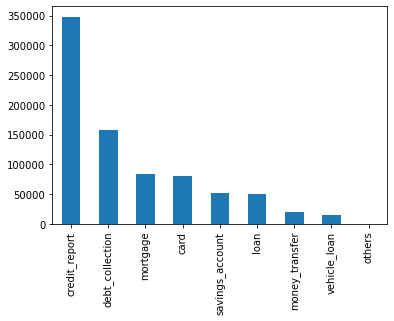

In [92]:
data.Product.value_counts().plot(kind = 'barh')

In [48]:
vocabulary[tokens[0][0]]

'i'

### Save the tokens

In [ ]:
save_file(tokens_path, tokens)

## Create PyTorch Dataset
---

In [49]:
class TextDataset(torch.utils.data.Dataset):

    def __init__(self, tokens, embeddings, labels):
        """
        :param tokens: List of word tokens
        :param embeddings: Word embeddings (from glove)
        :param labels: List of labels
        """
        self.tokens = tokens
        self.embeddings = embeddings
        self.labels = labels

    def __len__(self):
        return len(self.tokens)

    def __getitem__(self, idx):
        return self.labels[idx], self.embeddings[self.tokens[idx], :]

## Create Models
---

### RNN Model

In [50]:
class RNNNetwork(torch.nn.Module):

    def __init__(self, input_size, hidden_size, num_classes):
        """
        :param input_size: Size of embedding
        :param hidden_size: Hidden vector size
        :param num_classes: Number of classes in the dataset
        """
        super(RNNNetwork, self).__init__()
        # RNN Layer
        self.rnn = torch.nn.RNN(input_size=input_size,
                                hidden_size=hidden_size,
                                batch_first=True)
        # Linear Layer
        self.linear = torch.nn.Linear(hidden_size, num_classes)

    def forward(self, input_data):
        _, hidden = self.rnn(input_data)
        output = self.linear(hidden)
        return output

### LSTM Model

In [51]:
class LSTMNetwork(torch.nn.Module):

    def __init__(self, input_size, hidden_size, num_classes):
        """
        :param input_size: Size of embedding
        :param hidden_size: Hidden vector size
        :param num_classes: Number of classes in the dataset
        """
        super(LSTMNetwork, self).__init__()
        # LSTM Layer
        self.rnn = torch.nn.LSTM(input_size=input_size,
                                 hidden_size=hidden_size,
                                 batch_first=True)
        # Linear Layer
        self.linear = torch.nn.Linear(hidden_size, num_classes)

    def forward(self, input_data):
        _, (hidden, _) = self.rnn(input_data)
        output = self.linear(hidden[-1])
        return output

### Define train function

In [52]:
def train(train_loader, valid_loader, model, criterion, optimizer, device,
          num_epochs, model_path):
    """
    Function to train the model
    :param train_loader: Data loader for train dataset
    :param valid_loader: Data loader for validation dataset
    :param model: Model object
    :param criterion: Loss function
    :param optimizer: Optimizer
    :param device: CUDA or CPU
    :param num_epochs: Number of epochs
    :param model_path: Path to save the model
    """
    best_loss = 1e8
    for i in range(num_epochs):
        print(f"Epoch {i+1} of {num_epochs}")
        valid_loss, train_loss = [], []
        model.train()
        # Train loop
        for batch_labels, batch_data in tqdm(train_loader):
            # Move data to GPU if available
            batch_labels = batch_labels.to(device)
            batch_labels = batch_labels.type(torch.LongTensor)
            batch_data = batch_data.to(device)
            # Forward pass
            batch_output = model(batch_data)
            batch_output = torch.squeeze(batch_output)
            # Calculate loss
            loss = criterion(batch_output, batch_labels)
            train_loss.append(loss.item())
            optimizer.zero_grad()
            # Backward pass
            loss.backward()
            # Gradient update step
            optimizer.step()
        model.eval()
        # Validation loop
        for batch_labels, batch_data in tqdm(valid_loader):
            # Move data to GPU if available
            batch_labels = batch_labels.to(device)
            batch_labels = batch_labels.type(torch.LongTensor)
            batch_data = batch_data.to(device)
            # Forward pass
            batch_output = model(batch_data)
            batch_output = torch.squeeze(batch_output)
            # Calculate loss
            loss = criterion(batch_output, batch_labels)
            valid_loss.append(loss.item())
        t_loss = np.mean(train_loss)
        v_loss = np.mean(valid_loss)
        print(f"Train Loss: {t_loss}, Validation Loss: {v_loss}")
        if v_loss < best_loss:
            best_loss = v_loss
            # Save model if validation loss improves
            torch.save(model.state_dict(), model_path)
        print(f"Best Validation Loss: {best_loss}")

### Define test function

In [72]:
def test(test_loader, model, criterion, device):
    """
    Function to test the model
    :param test_loader: Data loader for test dataset
    :param model: Model object
    :param criterion: Loss function
    :param device: CUDA or CPU
    """
    model.eval()
    test_loss = []
    test_accu = []
    for batch_labels, batch_data in tqdm(test_loader):
        # Move data to device
        batch_labels = batch_labels.to(device)
        batch_labels = batch_labels.type(torch.LongTensor)
        batch_data = batch_data.to(device)
        # Forward pass
        batch_output = model(batch_data)
        batch_output = torch.squeeze(batch_output)
        # Calculate loss
        loss = criterion(batch_output, batch_labels)
        test_loss.append(loss.item())
        batch_preds = torch.argmax(batch_output, axis=1)
        # Move predictions to CPU
        if torch.cuda.is_available():
            batch_labels = batch_labels.cpu()
            batch_preds = batch_preds.cpu()
        # Compute accuracy
        test_accu.append(accuracy_score(batch_labels.detach().numpy(),
                                        batch_preds.detach().numpy()))
    test_loss = np.mean(test_loss)
    test_accu = np.mean(test_accu)
    print(f"Test Loss: {test_loss}, Test Accuracy: {test_accu}")

## Train RNN Model
---

### Load the files

In [60]:
tokens = load_file(tokens_path)
labels = load_file(labels_path)
embeddings = load_file(embeddings_path)
label_encoder = load_file(label_encoder_path)
num_classes = len(label_encoder.classes_)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.23.2 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


### Split data into train, validation and test sets

In [61]:
X_train, X_test, y_train, y_test = train_test_split(tokens, labels,
                                                    test_size=0.2)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train,
                                                      test_size=0.25)

### Create PyTorch datasets

In [62]:
train_dataset = TextDataset(X_train, embeddings, y_train)
valid_dataset = TextDataset(X_valid, embeddings, y_valid)
test_dataset = TextDataset(X_test, embeddings, y_test)

### Create data loaders

In [63]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16,
                                           shuffle=True, drop_last=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=16)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16)

### Create model object

In [64]:
model = RNNNetwork(input_size, hidden_size, num_classes)

### Move the model to GPU if available

In [65]:
if torch.cuda.is_available():
    model = model.cuda()

### Define loss function and optimizer

In [66]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Training loop

In [89]:
train(train_loader, valid_loader, model, criterion, optimizer,
      device, num_epochs, rnn_model_path)

Epoch 1 of 10


100%|████████████████████████████████████| 10117/10117 [00:28<00:00, 359.06it/s]


Train Loss: 0.6421072641196715, Validation Loss: 0.676749323365763
Best Validation Loss: 0.676749323365763
Epoch 2 of 10


100%|████████████████████████████████████| 10117/10117 [00:26<00:00, 384.23it/s]


Train Loss: 0.642107213073252, Validation Loss: 0.676749323365763
Best Validation Loss: 0.676749323365763
Epoch 3 of 10


100%|████████████████████████████████████| 10117/10117 [00:27<00:00, 372.79it/s]


Train Loss: 0.6421040648541105, Validation Loss: 0.676749323365763
Best Validation Loss: 0.676749323365763
Epoch 4 of 10


100%|████████████████████████████████████| 10117/10117 [00:28<00:00, 349.39it/s]


Train Loss: 0.64210391178273, Validation Loss: 0.676749323365763
Best Validation Loss: 0.676749323365763
Epoch 5 of 10


100%|████████████████████████████████████| 10117/10117 [00:27<00:00, 370.24it/s]


Train Loss: 0.6421035943898377, Validation Loss: 0.676749323365763
Best Validation Loss: 0.676749323365763
Epoch 6 of 10


100%|████████████████████████████████████| 10117/10117 [01:06<00:00, 151.26it/s]


Train Loss: 0.6421021523455517, Validation Loss: 0.676749323365763
Best Validation Loss: 0.676749323365763
Epoch 7 of 10


100%|████████████████████████████████████| 10117/10117 [00:32<00:00, 308.07it/s]


Train Loss: 0.6421109306769326, Validation Loss: 0.676749323365763
Best Validation Loss: 0.676749323365763
Epoch 8 of 10


100%|████████████████████████████████████| 10117/10117 [00:39<00:00, 257.71it/s]


Train Loss: 0.6421061017797551, Validation Loss: 0.676749323365763
Best Validation Loss: 0.676749323365763
Epoch 9 of 10


100%|████████████████████████████████████| 10117/10117 [00:28<00:00, 351.17it/s]


Train Loss: 0.6421085069333456, Validation Loss: 0.676749323365763
Best Validation Loss: 0.676749323365763
Epoch 10 of 10


100%|████████████████████████████████████| 10117/10117 [00:22<00:00, 450.26it/s]

Train Loss: 0.6421067217765668, Validation Loss: 0.676749323365763
Best Validation Loss: 0.676749323365763


In [90]:
test(test_loader, model, criterion, device)

100%|████████████████████████████████████| 10117/10117 [00:27<00:00, 374.36it/s]

Test Loss: 0.6800998210854695, Test Accuracy: 0.7700253191505539


## Train LSTM Model
---

In [68]:
model = LSTMNetwork(input_size, hidden_size, num_classes)

In [ ]:
if torch.cuda.is_available():
    model = model.cuda()

In [69]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [70]:
train(train_loader, valid_loader, model, criterion, optimizer,
      device, num_epochs, lstm_model_path)

Epoch 1 of 50


100%|████████████████████████████████████| 10117/10117 [00:25<00:00, 396.82it/s]


Train Loss: 1.0729198273977103, Validation Loss: 0.9000718026448936
Best Validation Loss: 0.9000718026448936
Epoch 2 of 50


100%|████████████████████████████████████| 10117/10117 [00:22<00:00, 452.81it/s]


Train Loss: 0.8608453140266644, Validation Loss: 0.823797575686835
Best Validation Loss: 0.823797575686835
Epoch 3 of 50


100%|████████████████████████████████████| 10117/10117 [00:22<00:00, 455.46it/s]


Train Loss: 0.8107744735658562, Validation Loss: 0.8022007622444088
Best Validation Loss: 0.8022007622444088
Epoch 4 of 50


100%|████████████████████████████████████| 10117/10117 [00:24<00:00, 406.58it/s]


Train Loss: 0.7832963553785394, Validation Loss: 0.7724441464895008
Best Validation Loss: 0.7724441464895008
Epoch 5 of 50


100%|████████████████████████████████████| 10117/10117 [00:31<00:00, 320.97it/s]


Train Loss: 0.7652324506493141, Validation Loss: 0.7770100166102261
Best Validation Loss: 0.7724441464895008
Epoch 6 of 50


100%|████████████████████████████████████| 10117/10117 [00:29<00:00, 340.11it/s]


Train Loss: 0.7518367845951726, Validation Loss: 0.7429941838318691
Best Validation Loss: 0.7429941838318691
Epoch 7 of 50


100%|████████████████████████████████████| 10117/10117 [00:26<00:00, 375.47it/s]


Train Loss: 0.7410353009687519, Validation Loss: 0.7410316939948163
Best Validation Loss: 0.7410316939948163
Epoch 8 of 50


100%|████████████████████████████████████| 10117/10117 [00:22<00:00, 453.44it/s]


Train Loss: 0.7318508983961931, Validation Loss: 0.7304120986255966
Best Validation Loss: 0.7304120986255966
Epoch 9 of 50


100%|████████████████████████████████████| 10117/10117 [00:22<00:00, 452.92it/s]


Train Loss: 0.7245690095591585, Validation Loss: 0.7244213231035321
Best Validation Loss: 0.7244213231035321
Epoch 10 of 50


100%|████████████████████████████████████| 10117/10117 [00:25<00:00, 404.63it/s]


Train Loss: 0.7183781006335721, Validation Loss: 0.7234061647667189
Best Validation Loss: 0.7234061647667189
Epoch 11 of 50


100%|████████████████████████████████████| 10117/10117 [00:22<00:00, 446.54it/s]


Train Loss: 0.7126599447578928, Validation Loss: 0.7188839431871618
Best Validation Loss: 0.7188839431871618
Epoch 12 of 50


100%|████████████████████████████████████| 10117/10117 [00:24<00:00, 412.26it/s]


Train Loss: 0.7077138639858861, Validation Loss: 0.7134556440060066
Best Validation Loss: 0.7134556440060066
Epoch 13 of 50


100%|████████████████████████████████████| 10117/10117 [00:23<00:00, 426.82it/s]


Train Loss: 0.703426656507729, Validation Loss: 0.7172939287846746
Best Validation Loss: 0.7134556440060066
Epoch 14 of 50


100%|████████████████████████████████████| 10117/10117 [00:22<00:00, 449.11it/s]


Train Loss: 0.6994239197641955, Validation Loss: 0.7050322210317699
Best Validation Loss: 0.7050322210317699
Epoch 15 of 50


100%|████████████████████████████████████| 10117/10117 [00:22<00:00, 451.24it/s]


Train Loss: 0.6960079471341026, Validation Loss: 0.7057309150607428
Best Validation Loss: 0.7050322210317699
Epoch 16 of 50


100%|████████████████████████████████████| 10117/10117 [00:22<00:00, 452.62it/s]


Train Loss: 0.6927428153221061, Validation Loss: 0.7018757802303087
Best Validation Loss: 0.7018757802303087
Epoch 17 of 50


100%|████████████████████████████████████| 10117/10117 [00:24<00:00, 410.24it/s]


Train Loss: 0.6898757897155386, Validation Loss: 0.6992979132215638
Best Validation Loss: 0.6992979132215638
Epoch 18 of 50


100%|████████████████████████████████████| 10117/10117 [00:22<00:00, 442.02it/s]


Train Loss: 0.6869735812816824, Validation Loss: 0.6962692540470727
Best Validation Loss: 0.6962692540470727
Epoch 19 of 50


100%|████████████████████████████████████| 10117/10117 [00:25<00:00, 395.74it/s]


Train Loss: 0.6844707319393287, Validation Loss: 0.6984595599931974
Best Validation Loss: 0.6962692540470727
Epoch 20 of 50


100%|████████████████████████████████████| 10117/10117 [00:23<00:00, 437.21it/s]


Train Loss: 0.6820878697340139, Validation Loss: 0.6963311041312878
Best Validation Loss: 0.6962692540470727
Epoch 21 of 50


100%|████████████████████████████████████| 10117/10117 [00:23<00:00, 430.62it/s]


Train Loss: 0.6797654543941015, Validation Loss: 0.6957075934891375
Best Validation Loss: 0.6957075934891375
Epoch 22 of 50


100%|████████████████████████████████████| 10117/10117 [00:19<00:00, 521.03it/s]


Train Loss: 0.6775353158790698, Validation Loss: 0.6918921579871121
Best Validation Loss: 0.6918921579871121
Epoch 23 of 50


100%|████████████████████████████████████| 10117/10117 [00:18<00:00, 542.51it/s]


Train Loss: 0.6754854063284652, Validation Loss: 0.6923834496531501
Best Validation Loss: 0.6918921579871121
Epoch 24 of 50


100%|████████████████████████████████████| 10117/10117 [00:22<00:00, 447.43it/s]


Train Loss: 0.6735642420450192, Validation Loss: 0.6888349795093752
Best Validation Loss: 0.6888349795093752
Epoch 25 of 50


100%|████████████████████████████████████| 10117/10117 [00:22<00:00, 453.69it/s]


Train Loss: 0.6717176657378723, Validation Loss: 0.6913746114221146
Best Validation Loss: 0.6888349795093752
Epoch 26 of 50


100%|████████████████████████████████████| 10117/10117 [00:22<00:00, 457.17it/s]


Train Loss: 0.6700293284315842, Validation Loss: 0.6882282175919785
Best Validation Loss: 0.6882282175919785
Epoch 27 of 50


100%|████████████████████████████████████| 10117/10117 [00:22<00:00, 451.87it/s]


Train Loss: 0.6682799104511541, Validation Loss: 0.693531583184173
Best Validation Loss: 0.6882282175919785
Epoch 28 of 50


100%|████████████████████████████████████| 10117/10117 [00:22<00:00, 458.07it/s]


Train Loss: 0.6667931203225005, Validation Loss: 0.6859006275217312
Best Validation Loss: 0.6859006275217312
Epoch 29 of 50


100%|████████████████████████████████████| 10117/10117 [00:21<00:00, 460.59it/s]


Train Loss: 0.6653184106965631, Validation Loss: 0.6862338281084606
Best Validation Loss: 0.6859006275217312
Epoch 30 of 50


100%|████████████████████████████████████| 10117/10117 [00:22<00:00, 458.93it/s]


Train Loss: 0.664023897885368, Validation Loss: 0.6848047040833708
Best Validation Loss: 0.6848047040833708
Epoch 31 of 50


100%|████████████████████████████████████| 10117/10117 [00:22<00:00, 446.85it/s]


Train Loss: 0.6625233287699337, Validation Loss: 0.6840123624530832
Best Validation Loss: 0.6840123624530832
Epoch 32 of 50


100%|████████████████████████████████████| 10117/10117 [00:22<00:00, 450.69it/s]


Train Loss: 0.6613030260830774, Validation Loss: 0.6842190379683203
Best Validation Loss: 0.6840123624530832
Epoch 33 of 50


100%|████████████████████████████████████| 10117/10117 [00:22<00:00, 449.59it/s]


Train Loss: 0.6600771185373995, Validation Loss: 0.6814027877175237
Best Validation Loss: 0.6814027877175237
Epoch 34 of 50


100%|████████████████████████████████████| 10117/10117 [00:21<00:00, 462.68it/s]


Train Loss: 0.6589221169871985, Validation Loss: 0.6831236590718851
Best Validation Loss: 0.6814027877175237
Epoch 35 of 50


100%|████████████████████████████████████| 10117/10117 [00:19<00:00, 509.57it/s]


Train Loss: 0.6577787225510575, Validation Loss: 0.6815928108931277
Best Validation Loss: 0.6814027877175237
Epoch 36 of 50


100%|████████████████████████████████████| 10117/10117 [00:26<00:00, 375.52it/s]


Train Loss: 0.6566388851485201, Validation Loss: 0.6811578288130125
Best Validation Loss: 0.6811578288130125
Epoch 37 of 50


100%|████████████████████████████████████| 10117/10117 [00:25<00:00, 397.93it/s]


Train Loss: 0.6555894215819863, Validation Loss: 0.6817985011377542
Best Validation Loss: 0.6811578288130125
Epoch 38 of 50


100%|████████████████████████████████████| 10117/10117 [00:23<00:00, 428.20it/s]


Train Loss: 0.6544836190767599, Validation Loss: 0.6815251208881569
Best Validation Loss: 0.6811578288130125
Epoch 39 of 50


100%|████████████████████████████████████| 10117/10117 [00:25<00:00, 390.12it/s]


Train Loss: 0.6534507282912928, Validation Loss: 0.6785949477855014
Best Validation Loss: 0.6785949477855014
Epoch 40 of 50


100%|████████████████████████████████████| 10117/10117 [00:22<00:00, 447.41it/s]


Train Loss: 0.6525584463089017, Validation Loss: 0.682155807804785
Best Validation Loss: 0.6785949477855014
Epoch 41 of 50


100%|████████████████████████████████████| 10117/10117 [00:25<00:00, 404.04it/s]


Train Loss: 0.6516443012932184, Validation Loss: 0.6773195634097571
Best Validation Loss: 0.6773195634097571
Epoch 42 of 50


100%|████████████████████████████████████| 10117/10117 [00:18<00:00, 532.82it/s]


Train Loss: 0.6505885562919314, Validation Loss: 0.6811721796228608
Best Validation Loss: 0.6773195634097571
Epoch 43 of 50


100%|████████████████████████████████████| 10117/10117 [00:18<00:00, 539.91it/s]


Train Loss: 0.6498548589433241, Validation Loss: 0.6833768980812329
Best Validation Loss: 0.6773195634097571
Epoch 44 of 50


100%|████████████████████████████████████| 10117/10117 [00:18<00:00, 549.07it/s]


Train Loss: 0.6488350846534948, Validation Loss: 0.6823069485031629
Best Validation Loss: 0.6773195634097571
Epoch 45 of 50


100%|████████████████████████████████████| 10117/10117 [00:18<00:00, 545.13it/s]


Train Loss: 0.6481770151433776, Validation Loss: 0.676749323365763
Best Validation Loss: 0.676749323365763
Epoch 46 of 50


100%|████████████████████████████████████| 10117/10117 [00:18<00:00, 537.46it/s]


Train Loss: 0.6475325646071006, Validation Loss: 0.679196721448238
Best Validation Loss: 0.676749323365763
Epoch 47 of 50


100%|████████████████████████████████████| 10117/10117 [00:18<00:00, 541.75it/s]


Train Loss: 0.6466896621698799, Validation Loss: 0.6793607003074384
Best Validation Loss: 0.676749323365763
Epoch 48 of 50


100%|████████████████████████████████████| 10117/10117 [00:18<00:00, 545.66it/s]


Train Loss: 0.6457014830712432, Validation Loss: 0.6783172730767021
Best Validation Loss: 0.676749323365763
Epoch 49 of 50


100%|████████████████████████████████████| 10117/10117 [00:18<00:00, 546.20it/s]


Train Loss: 0.6451129358742982, Validation Loss: 0.6769056852829248
Best Validation Loss: 0.676749323365763
Epoch 50 of 50


100%|████████████████████████████████████| 10117/10117 [00:19<00:00, 515.61it/s]

Train Loss: 0.6443483572821493, Validation Loss: 0.6790276773762206
Best Validation Loss: 0.676749323365763


In [73]:
test(test_loader, model, criterion, device)

100%|████████████████████████████████████| 10117/10117 [00:27<00:00, 373.14it/s]

Test Loss: 0.6830420606747805, Test Accuracy: 0.7689874620782994


## Predict on new text
---

In [74]:
input_text = '''I am a victim of Identity Theft & currently have an Experian account that 
I can view my Experian Credit Report and getting notified when there is activity on 
my Experian Credit Report. For the past 3 days I've spent a total of approximately 9 
hours on the phone with Experian. Every time I call I get transferred repeatedly and 
then my last transfer and automated message states to press 1 and leave a message and 
someone would call me. Every time I press 1 I get an automatic message stating than you 
before I even leave a message and get disconnected. I call Experian again, explain what 
is happening and the process begins again with the same end result. I was trying to have 
this issue attended and resolved informally but I give up after 9 hours. There are hard 
hit inquiries on my Experian Credit Report that are fraud, I didn't authorize, or recall 
and I respectfully request that Experian remove the hard hit inquiries immediately just 
like they've done in the past when I was able to speak to a live Experian representative 
in the United States. The following are the hard hit inquiries : BK OF XXXX XX/XX/XXXX 
XXXX XXXX XXXX  XX/XX/XXXX XXXX  XXXX XXXX  XX/XX/XXXX XXXX  XX/XX/XXXX XXXX  XXXX 
XX/XX/XXXX'''

### Process input text

In [75]:
input_text = input_text.lower()
input_text = re.sub(r"[^\w\d'\s]+", " ", input_text)
input_text = re.sub("\d+", "", input_text)
input_text = re.sub(r'[x]{2,}', "", input_text)
input_text = re.sub(' +', ' ', input_text)
tokens = word_tokenize(input_text)

### Add padding if the length of tokens is less than 20

In [76]:
tokens = ['<pad>']*(20-len(tokens))+tokens

### Tokenize the input text

In [77]:
idx_token = []
for token in tokens:
    if token in vocabulary:
        idx_token.append(vocabulary.index(token))
    else:
        idx_token.append(vocabulary.index('<unk>'))

### Get embeddings for tokens

In [78]:
token_emb = embeddings[idx_token,:]

### Convert to torch tensor

In [79]:
inp = torch.from_numpy(token_emb)

### Move the tensor to GPU if available

In [80]:
inp = inp.to(device)

### Create a batch of one record

In [81]:
inp = torch.unsqueeze(inp, 0)

### Load label encoder

In [82]:
label_encoder = load_file(label_encoder_path)
num_classes = len(label_encoder.classes_)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.23.2 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [83]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### RNN prediction

In [84]:
# Create model object
model = RNNNetwork(input_size, hidden_size, num_classes)

# Load trained weights
model.load_state_dict(torch.load(rnn_model_path))

# Move the model to GPU if available
if torch.cuda.is_available():
    model = model.cuda()
    
# Forward pass
out = torch.squeeze(model(inp))

# Find predicted class
prediction = label_encoder.classes_[torch.argmax(out)]
print(f"Predicted  Class: {prediction}")

Predicted  Class: credit_report


### LSTM prediction

In [85]:
# Create model object
model = LSTMNetwork(input_size, hidden_size, num_classes)

# Load trained weights
model.load_state_dict(torch.load(lstm_model_path))

# Move the model to GPU if available
if torch.cuda.is_available():
    model = model.cuda()
    
# Forward pass
out = torch.squeeze(model(inp))

# Find predicted class
prediction = label_encoder.classes_[torch.argmax(out)]
print(f"Predicted  Class: {prediction}")

Predicted  Class: credit_report
